In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from datetime import date
np.set_printoptions(suppress=True)


In [38]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 51)

In [39]:
csv_file_list = []
for i in os.listdir():
    if '.csv' in i.lower():
        csv_file_list.append(i)

In [40]:
def chase_checking_cleaner(frame):
    frame = frame.rename(columns={'Posting Date': 'Date'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    return frame
    

In [41]:
def chase_credit_cleaner(frame):
    frame = frame.drop('Post Date',axis=1)
    frame = frame.drop('Memo', axis=1)
    
    frame = frame.rename(columns={'Transaction Date':'Date'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    frame['Amount'] = frame['Amount'] * -1
    return frame
    

In [42]:
def amex_credit_cleaner(frame):
    frame['Date'] = pd.to_datetime(frame['Date'])
    return frame
    

In [47]:
df = pd.DataFrame()
for i in csv_file_list:
    if 'amex' in i.lower():
        temp_df = pd.read_csv(i)
        
        temp_df = amex_credit_cleaner(temp_df)

        temp_df['file_name'] = i.split('.')[0]
        
        df = pd.concat([df, temp_df])
        # print('hello')
    elif ('chase' in i.lower()) & ('credit' in i.lower()):
        temp_df = pd.read_csv(i)
       
        # Transform to fit amex transactions
        temp_df = chase_credit_cleaner(temp_df)

        temp_df['file_name'] = i.split('.')[0]
       
        df = pd.concat([df, temp_df])
    elif ('chase' in i.lower()) & ('checking' in i.lower()):
        temp_df = pd.read_csv(i,index_col=False)
        temp_df = chase_checking_cleaner(temp_df)
        temp_df['file_name'] = i.split('.')[0]

        df = pd.concat([df, temp_df])

In [48]:
df = df.reset_index(drop=True)

In [53]:
df['bank'] = df['file_name'].str.split('_').str[0]
df['account_type'] = df['file_name'].str.split('_').str[1]
df['account_number'] = df['file_name'].str.split('_').str[2]

In [54]:
df['month_name'] = df['Date'].dt.month_name()
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year.astype('Int64')

In [55]:
df

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,file_name,Details,Type,Balance,Check or Slip #,bank,account_type,account_number,month_name,month,year
0,2022-12-29,MOBILE PAYMENT - THANK YOU,BRUCE LOMBARD,-91002.0,-2673.40,MOBILE PAYMENT - THANK YOU,MOBILE PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320223630765283073',NaN,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,amex,credit,1002,December,12,2022
1,2022-12-21,THE DISNEY BUNDLE CREDIT,BRUCE LOMBARD,-91002.0,-7.00,THE DISNEY BUNDLE CREDIT,THE DISNEY BUNDLE CREDIT,2500 BROADWAY,SANTA MONICA\r\nCA,90404-3065,UNITED STATES,'320223550614393280',Communications-Cable & Internet Comm,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,amex,credit,1002,December,12,2022
2,2022-12-17,1707 S WASHINGTON STNAPERVILLE IL,BRUCE LOMBARD,-91002.0,49.49,00000004401 6303550157\r\n1707 S WASHINGTON ST...,1707 S WASHINGTON STNAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\r\nTX,77067-2552,UNITED STATES,'320223520535625915',Transportation-Fuel,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,amex,credit,1002,December,12,2022
3,2022-12-17,JEWEL OSCO 1111 1111NAPERVILLE IL,BRUCE LOMBARD,-91002.0,35.92,0124137 800-898-4027\r\nJEWEL OSCO 1111 11...,JEWEL OSCO 1111 1111NAPERVILLE IL,1227 NAPER BLVD,NAPERVILLE\r\nIL,60540,UNITED STATES,'320223520526343876',Merchandise & Supplies-Groceries,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,amex,credit,1002,December,12,2022
4,2022-12-17,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002.0,90.91,0C2LHY492MF 6305797700\r\nWHOLEFDS NPV 10129 0...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\r\nIL,60540,UNITED STATES,'320223520532548570',Merchandise & Supplies-Groceries,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,amex,credit,1002,December,12,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,2022-06-15,BROWN BAG SEAFOOD,NaN,NaN,55.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Food & Drink,Chase_credit_4649_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,4649,June,6,2022
3192,2022-06-13,BYTE,NaN,NaN,89.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Health & Wellness,Chase_credit_4649_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,4649,June,6,2022
3193,2022-06-13,Payment Thank You - Web,NaN,NaN,-972.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_credit_4649_20220611_20240611,NaN,Payment,NaN,NaN,Chase,credit,4649,June,6,2022
3194,2022-06-11,CITY OF NAPERVILLE,NaN,NaN,176.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bills & Utilities,Chase_credit_4649_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,4649,June,6,2022


In [56]:
#create conditions to filter results that do no benefit from removing numbers and spaces from the Description column
## default result removes all numbers and extra spaces from the description column

cond = [
    df['Description'].str.contains('amex',case=False),
]

choice = [
    df['Description'],
]

default_cond = df['Description'].str.replace(r'\d+','',regex=True).str.replace(r'\s+'," ", regex=True)

df['clean_description'] = np.select(condlist=cond,choicelist=choice,default=default_cond)



In [57]:
df = df.sort_values(['clean_description', 'year','month','Amount'],ascending=[True,False,False, True])

In [58]:
shift_date = df.shift(-1)['Date'].dt.month.astype('Int8')
date_offset = (df['Date'] - pd.DateOffset(months=1)).dt.month
shift_amount = df.shift(-1)['Amount']

In [59]:
df['is_recurring'] = (shift_date == date_offset) & (df['Amount'] == shift_amount)

In [117]:
#Need to create an always recurring function to flag transactions that are always considered to be recurring

In [60]:
df['month_year'] = df['month_name'].str[:3] + "-" + df['year'].astype('str')

In [61]:
recur = df[df['is_recurring'] == True]

In [70]:
# recur2 = 
recur['adjusted_amount'] = np.where(recur['account_type']=='credit',recur['Amount']*-1,recur['Amount'])

C:\Users\blomb\AppData\Local\Temp\ipykernel_32888\3219907641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recur['adjusted_amount'] = np.where(recur['account_type']=='credit',recur['Amount']*-1,recur['Amount'])


In [76]:
recur = recur.sort_values('Date')

In [78]:
recur_group = recur.groupby('month_year',as_index=False,sort=False)['adjusted_amount'].sum()

In [93]:
recur_group['adjusted_amount'] = recur_group['adjusted_amount']*-1

In [110]:
recur_group

,month_year,adjusted_amount
0,Jul-2022,2524.30
1,Aug-2022,6759.10
2,Sep-2022,6696.43
3,Oct-2022,7183.45
4,Nov-2022,6681.46
5,Dec-2022,1492.31
6,Jan-2023,7639.67
7,Feb-2023,1517.54
8,Mar-2023,7658.27
9,Apr-2023,7521.90


In [116]:
recur[recur['month_year'] == 'Jun-2023']

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,file_name,Details,Type,Balance,Check or Slip #,bank,account_type,account_number,month_name,month,year,clean_description,is_recurring,month_year,adjusted_amount
2307,2023-06-02,KESAP CLEAN,NaN,NaN,185.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home,Chase_credit_4434_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,4434,June,6,2023,KESAP CLEAN,True,Jun-2023,-185.00
1702,2023-06-04,RITUAL (RITUAL.COM),NaN,NaN,39.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Groceries,Chase_credit_3326_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,3326,June,6,2023,RITUAL (RITUAL.COM),True,Jun-2023,-39.29
3012,2023-06-04,FOREIGN TRANSACTION FEE,NaN,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fees & Adjustments,Chase_credit_4649_20220611_20240611,NaN,Fee,NaN,NaN,Chase,credit,4649,June,6,2023,FOREIGN TRANSACTION FEE,True,Jun-2023,-0.25
3010,2023-06-08,Roku for Showtime Digital,NaN,NaN,10.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bills & Utilities,Chase_credit_4649_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,4649,June,6,2023,Roku for Showtime Digital,True,Jun-2023,-10.99
3009,2023-06-09,STAX *AKITA SECURIT,NaN,NaN,45.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Professional Services,Chase_credit_4649_20220611_20240611,NaN,Sale,NaN,NaN,Chase,credit,4649,June,6,2023,STAX *AKITA SECURIT,True,Jun-2023,-45.39
1030,2023-06-09,GLANBIA PERFORMA DIRECT DEP PP...,NaN,NaN,5810.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,CREDIT,ACH_CREDIT,13456.26,NaN,Chase,checking,9333,June,6,2023,GLANBIA PERFORMA DIRECT DEP PPD ID:,True,Jun-2023,5810.31
201,2023-06-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\r\nHULU 877-8244858 ...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\r\nCA,90404-3065,UNITED STATES,'320231670680766177',Communications-Cable & Internet Comm,amex_credit_1002_bce_2023,NaN,NaN,NaN,NaN,amex,credit,1002,June,6,2023,HULU - CA HULU.COM/BILL CA,True,Jun-2023,-19.99
1022,2023-06-20,ALLY LENDING 888568018 888-5680186 NY 0...,NaN,NaN,-124.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,DEBIT_CARD,6438.44,NaN,Chase,checking,9333,June,6,2023,ALLY LENDING - NY /,True,Jun-2023,-124.91
199,2023-06-22,THE DISNEY BUNDLE CREDIT,BRUCE LOMBARD,-91002.0,-7.00,THE DISNEY BUNDLE CREDIT,THE DISNEY BUNDLE CREDIT,2500 BROADWAY,SANTA MONICA\r\nCA,90404-3065,UNITED STATES,'320231730844194406',Communications-Cable & Internet Comm,amex_credit_1002_bce_2023,NaN,NaN,NaN,NaN,amex,credit,1002,June,6,2023,THE DISNEY BUNDLE CREDIT,True,Jun-2023,7.00
1017,2023-06-23,"AUDI FINCL, INC. AUTO DEBIT 000008122144714 WE...",NaN,NaN,-665.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,13760.20,NaN,Chase,checking,9333,June,6,2023,"AUDI FINCL, INC. AUTO DEBIT WEB ID:",True,Jun-2023,-665.79


C:\Users\blomb\AppData\Local\Temp\ipykernel_32888\2426741402.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(recur_group, x='month_year', y='adjusted_amount',palette='viridis')


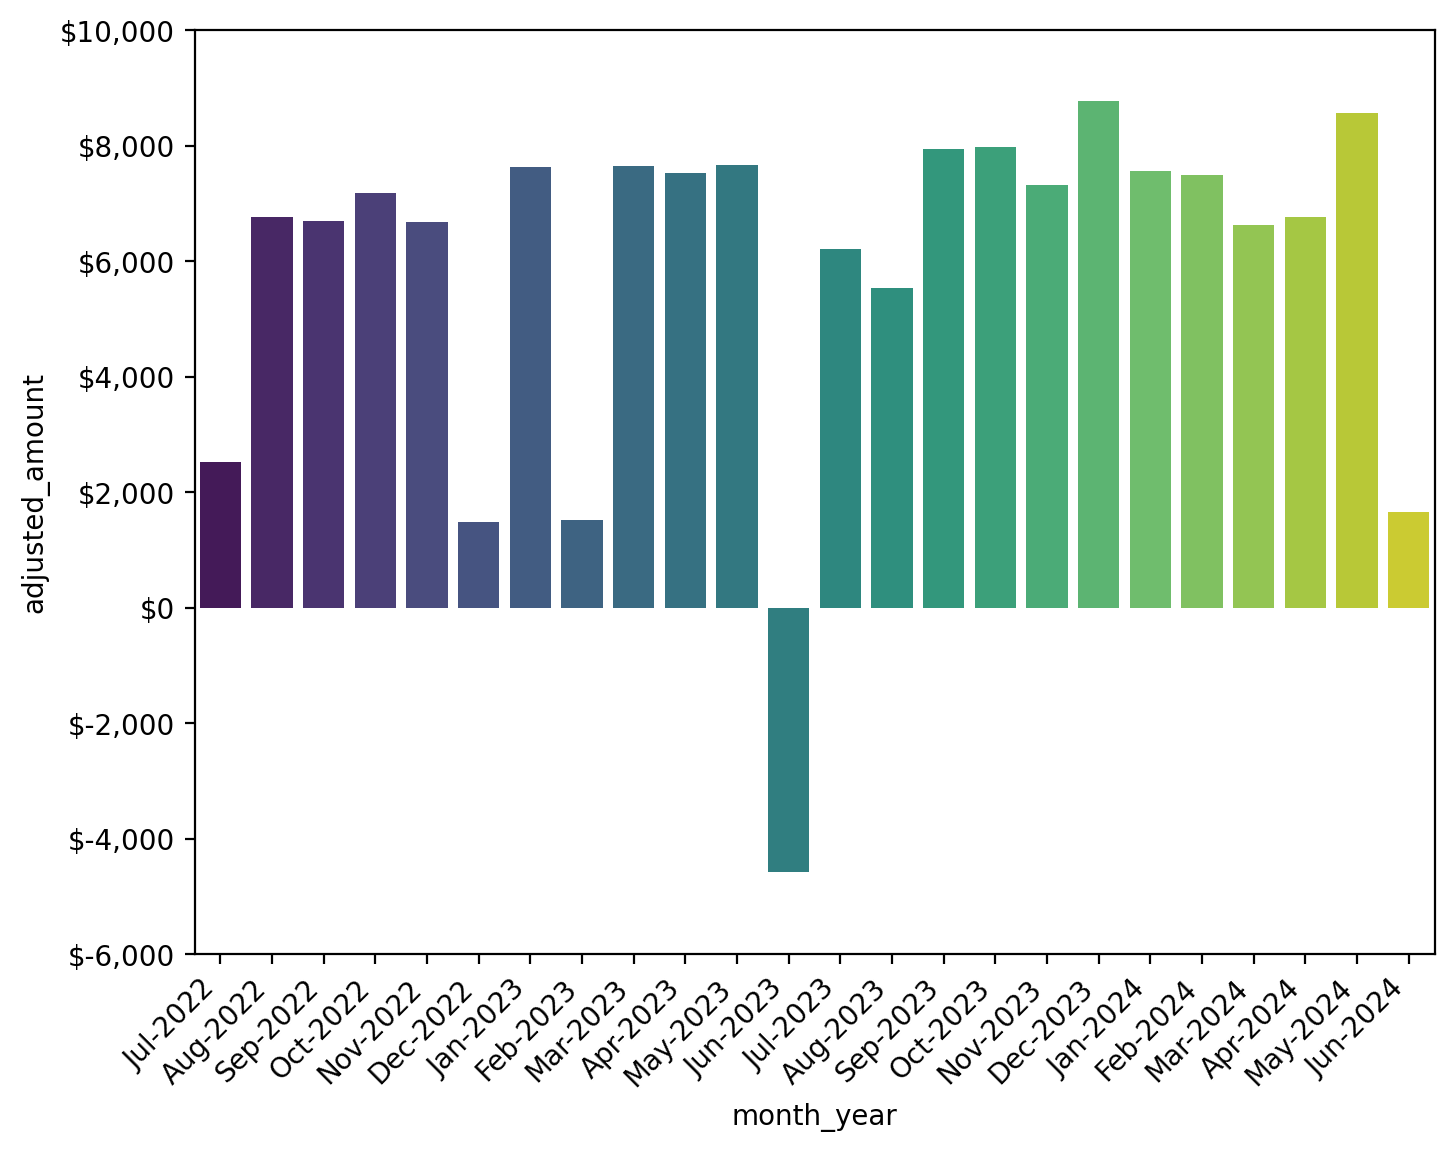

In [114]:

plt.figure(figsize=(8,6), dpi=200)
g = sns.barplot(recur_group, x='month_year', y='adjusted_amount',palette='viridis')
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(ticks =[x for x in g.get_yticks()],labels=['${:,.0f}'.format(x) for x in g.get_yticks()])
plt.show()

In [102]:
g.get_yticks()

array([-6000., -4000., -2000.,     0.,  2000.,  4000.,  6000.,  8000.,
       10000.])

In [18]:
(df['Date'] - pd.DateOffset(months=1)).dt.month


295      4
298      3
302      2
307      1
310     12
        ..
2508     9
2848     1
2616     5
2002     5
1988     5
Name: Date, Length: 3196, dtype: int32

In [118]:
dups = df[df.duplicated(subset=['Amount','Description'],keep=False)]

In [171]:
target = df[(df['Description'].str.contains('Hulu',case=False)) & (df['month'] =='April') & (df['year'] == 2024)]

In [181]:
offset_date = (target['Date'] - pd.DateOffset(months=1)).dt.month_name().to_string(index=False)

In [182]:
offset_date

'March'

In [152]:
offset_date.values

array(['March'], dtype=object)

In [156]:
target['Description'].values

array(['HLU*HULU 15905810150HULU.COM/BILL       CA'], dtype=object)

In [154]:
target

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Type,Balance,Check or Slip #,month,year
229,2023-04-16,HLU*HULU 15905810150HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHLU*HULU 1590581015...,HLU*HULU 15905810150HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320231060213805197',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,April,2023


In [172]:
targ_desc = target['Description'].to_string(index=False)


In [175]:
targ_amount = float(target['Amount'].to_string(index=False))

In [160]:
df['Description']

0                       MOBILE PAYMENT - THANK YOU
1                         THE DISNEY BUNDLE CREDIT
2       1707 S WASHINGTON STNAPERVILLE          IL
3       JEWEL OSCO 1111 1111NAPERVILLE          IL
4       WHOLEFDS NPV 10129 0NAPERVILLE          IL
                           ...                    
3191                        AMZN Mktp US*CH54M2L93
3192                          Amazon.com*ZZ5KN1UL3
3193                        AMZN Mktp US*E93MN19E3
3194                        AMZN Mktp US*EX2KA54K3
3195                         Prime Video*UA9GJ0Y73
Name: Description, Length: 3196, dtype: object

In [184]:
df[(df['Description'] == targ_desc) & (df['Amount'] == targ_amount) & (df['month'] == offset_date) ]
# & (df['Amount'] == target['Amount'])

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Type,Balance,Check or Slip #,month,year
303,2024-03-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,24.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320240760339371588',Communications-Cable & Internet Comm,amex_bce_2024_ytd,NaN,NaN,NaN,NaN,March,2024


In [143]:
target

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Type,Balance,Check or Slip #,month,year
229,2023-04-16,HLU*HULU 15905810150HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHLU*HULU 1590581015...,HLU*HULU 15905810150HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320231060213805197',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,April,2023


In [170]:
df[(df['Description'].str.contains('Hulu',case=False))]

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Type,Balance,Check or Slip #,month,year
8,2022-12-16,HLU*HULU 15905810184HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:K HULU.COM/BILL\nHLU*HULU 1590581018...,HLU*HULU 15905810184HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320223500493689648',Communications-Cable & Internet Comm,amex_bce_2022,NaN,NaN,NaN,NaN,December,2022
123,2023-12-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,24.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320233500168633321',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,December,2023
128,2023-11-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,24.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320233200391028914',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,November,2023
139,2023-10-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,24.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232890638272587',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,October,2023
154,2023-09-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232590910917389',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,September,2023
171,2023-08-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232280162050539',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,August,2023
187,2023-07-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320231970405677166',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,July,2023
201,2023-06-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320231670680766177',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,June,2023
216,2023-05-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320231360930051629',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,May,2023
229,2023-04-16,HLU*HULU 15905810150HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHLU*HULU 1590581015...,HLU*HULU 15905810150HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320231060213805197',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,April,2023


,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Type,Balance,Check or Slip #,month,year
0,2022-12-29,MOBILE PAYMENT - THANK YOU,BRUCE LOMBARD,-91002.0,-2673.40,MOBILE PAYMENT - THANK YOU,MOBILE PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320223630765283073',NaN,amex_bce_2022,NaN,NaN,NaN,NaN,December,2022
1,2022-12-21,THE DISNEY BUNDLE CREDIT,BRUCE LOMBARD,-91002.0,-7.00,THE DISNEY BUNDLE CREDIT,THE DISNEY BUNDLE CREDIT,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320223550614393280',Communications-Cable & Internet Comm,amex_bce_2022,NaN,NaN,NaN,NaN,December,2022
2,2022-12-17,1707 S WASHINGTON STNAPERVILLE IL,BRUCE LOMBARD,-91002.0,49.49,00000004401 6303550157\n1707 S WASHINGTON ST 5...,1707 S WASHINGTON STNAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\nTX,77067-2552,UNITED STATES,'320223520535625915',Transportation-Fuel,amex_bce_2022,NaN,NaN,NaN,NaN,December,2022
3,2022-12-17,JEWEL OSCO 1111 1111NAPERVILLE IL,BRUCE LOMBARD,-91002.0,35.92,0124137 800-898-4027\nJEWEL OSCO 1111 1111...,JEWEL OSCO 1111 1111NAPERVILLE IL,1227 NAPER BLVD,NAPERVILLE\nIL,60540,UNITED STATES,'320223520526343876',Merchandise & Supplies-Groceries,amex_bce_2022,NaN,NaN,NaN,NaN,December,2022
4,2022-12-17,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002.0,90.91,0C2LHY492MF 6305797700\nWHOLEFDS NPV 10129 000...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\nIL,60540,UNITED STATES,'320223520532548570',Merchandise & Supplies-Groceries,amex_bce_2022,NaN,NaN,NaN,NaN,December,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,2022-06-12,AMZN Mktp US*CH54M2L93,NaN,NaN,51.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shopping,Chase_credit_bruce_4434_20220611_20240611,NaN,Sale,NaN,NaN,June,2022
3192,2022-06-12,Amazon.com*ZZ5KN1UL3,NaN,NaN,307.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Groceries,Chase_credit_bruce_4434_20220611_20240611,NaN,Sale,NaN,NaN,June,2022
3193,2022-06-11,AMZN Mktp US*E93MN19E3,NaN,NaN,53.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shopping,Chase_credit_bruce_4434_20220611_20240611,NaN,Sale,NaN,NaN,June,2022
3194,2022-06-11,AMZN Mktp US*EX2KA54K3,NaN,NaN,42.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shopping,Chase_credit_bruce_4434_20220611_20240611,NaN,Sale,NaN,NaN,June,2022


In [ ]:
def reoccuring():
    

In [208]:
df['Date'].shift(periods=1, freq='m')

C:\Users\blomb\AppData\Local\Temp\ipykernel_38012\3459022191.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.shift(periods=1, freq='m')


NotImplementedError: This method is only implemented for DatetimeIndex, PeriodIndex and TimedeltaIndex; Got type RangeIndex

In [200]:
for i in df.index:
    
    targ_desc = df.loc[i, 'Description']
    targ_amount = df.loc[i,'Amount']
    targ_offset = (df.loc[i,'Date'] - pd.DateOffset(months=1)).month_name()
    
    # print(df.loc[i,'Description'])
    # print(type(targ_amount))
    # df.iloc[i]

November
November
November
November
November
November
November
November
November
November
November
November
November
November
November
November
November
October
October
October
October
October
October
October
October
October
October
October
October
October
October
October
October
September
September
September
September
September
September
September
September
September
September
September
September
September
September
September
September
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
August
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
July
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
June
May
May
May
May
May
May
November
November
November
November
November
November
October
October
October
October
October
October
September
September
September
September
September
September
Septem

In [112]:
dups[dups['Description'].str.contains('Kids', case=False)]

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Type,Balance,Check or Slip #,month,year
361,2022-09-30,KIDSNIPS NAPERVILLE NAPERVILLE IL,BRUCE LOMBARD,-71004.0,32.0,21105172274 BEAUTY/BARBER SHOP\nKIDSNIPS NAPER...,KIDSNIPS NAPERVILLE NAPERVILLE IL,2835 SHOWPLACE DR,NAPERVILLE\nIL,60564,UNITED STATES,'320222740748280584',Business Services-Other Services,amex_gold_2022,NaN,NaN,NaN,NaN,September,2022
477,2023-11-26,KIDSNIPS NAPERVILLE NAPERVILLE IL,BRUCE LOMBARD,-71004.0,27.0,21105173331 BEAUTY/BARBER SHOP\nKIDSNIPS NAPER...,KIDSNIPS NAPERVILLE NAPERVILLE IL,2835 SHOWPLACE DR,NAPERVILLE\nIL,60564,UNITED STATES,'320233310680118938',Business Services-Other Services,amex_gold_2023,NaN,NaN,NaN,NaN,November,2023
613,2023-01-08,KIDSNIPS NAPERVILLE NAPERVILLE IL,BRUCE LOMBARD,-71004.0,27.0,21105173009 BEAUTY/BARBER SHOP\nKIDSNIPS NAPER...,KIDSNIPS NAPERVILLE NAPERVILLE IL,2835 SHOWPLACE DR,NAPERVILLE\nIL,60564,UNITED STATES,'320230090015447388',Business Services-Other Services,amex_gold_2023,NaN,NaN,NaN,NaN,January,2023
745,2024-05-20,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,15996.72,NaN,May,2024
754,2024-05-06,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,18185.59,NaN,May,2024
769,2024-04-22,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,8381.39,NaN,April,2024
806,2024-02-26,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,9693.76,NaN,February,2024
815,2024-02-12,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,13319.48,NaN,February,2024
866,2023-12-18,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,14977.89,NaN,December,2023
877,2023-12-04,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_Activity_20240611,DEBIT,ACH_DEBIT,19407.58,NaN,December,2023


In [102]:
dups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, 105 to 3173
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          470 non-null    object 
 1   Description                   470 non-null    object 
 2   Card Member                   81 non-null     object 
 3   Account #                     81 non-null     float64
 4   Amount                        470 non-null    float64
 5   Extended Details              81 non-null     object 
 6   Appears On Your Statement As  81 non-null     object 
 7   Address                       72 non-null     object 
 8   City/State                    72 non-null     object 
 9   Zip Code                      72 non-null     object 
 10  Country                       72 non-null     object 
 11  Reference                     81 non-null     object 
 12  Category                      356 non-null    object 
 13  File_na

In [101]:
dups[['Date','Description','Amount']].sort_values('Date')

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [83]:
dups.groupby(['Description','Amount','Date'])['Date'].transform('min')[:40]

105   2022-07-16
126   2023-11-27
127   2023-11-23
128   2023-11-16
135   2023-10-19
139   2023-10-16
153   2023-09-18
170   2023-08-19
171   2023-08-16
179   2023-07-27
184   2023-07-20
187   2023-07-16
197   2023-06-27
199   2023-06-22
201   2023-06-16
204   2023-06-07
211   2023-05-28
213   2023-05-25
216   2023-05-16
227   2023-04-21
248   2023-03-20
262   2023-02-25
265   2023-02-20
278   2023-01-28
283   2023-01-21
288   2023-01-13
294   2024-05-28
295   2024-05-20
296   2024-05-16
298   2024-04-18
300   2024-04-16
302   2024-03-20
303   2024-03-16
306   2024-02-26
307   2024-02-23
308   2024-02-16
310   2024-01-24
312   2024-01-16
317   2022-12-16
332   2022-11-08
Name: Date, dtype: datetime64[ns]

In [81]:
dups[:40]

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Posting Date,Type,Balance,Check or Slip #,month,year
105,2022-07-16,STARBUCKS 800-782-7282 WA,BRUCE LOMBARD,-91002.0,25.00,3VUPB1NTF1Q GIFT CARD\nSTARBUCKS\n800-782-7282...,STARBUCKS 800-782-7282 WA,2401 UTAH AVE SOUTH STE 800,SEATTLE\nWA,98134,UNITED STATES,'320221980076537611',Restaurant-Bar & Café,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,July,2022
126,2023-11-27,AUTOPAY PAYMENT - THANK YOU,BRUCE LOMBARD,-91002.0,-40.00,AUTOPAY PAYMENT - THANK YOU,AUTOPAY PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320233310658888921',NaN,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,November,2023
127,2023-11-23,$84 Disney Bundle Credit,BRUCE LOMBARD,-91002.0,-7.00,$84 Disney Bundle Credit,$84 Disney Bundle Credit,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320233270589608071',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,November,2023
128,2023-11-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,24.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320233200391028914',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,November,2023
135,2023-10-19,$84 Disney Bundle Credit,BRUCE LOMBARD,-91002.0,-7.00,$84 Disney Bundle Credit,$84 Disney Bundle Credit,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232920730784528',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,October,2023
139,2023-10-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,24.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232890638272587',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,October,2023
153,2023-09-18,$84 Disney Bundle Credit,BRUCE LOMBARD,-91002.0,-7.00,$84 Disney Bundle Credit,$84 Disney Bundle Credit,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232610975238615',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,September,2023
170,2023-08-19,THE DISNEY BUNDLE CREDIT,BRUCE LOMBARD,-91002.0,-7.00,THE DISNEY BUNDLE CREDIT,THE DISNEY BUNDLE CREDIT,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232310257757947',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,August,2023
171,2023-08-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,19.99,427814995:7 HULU.COM/BILL\nHULU 877-8244858 CA...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320232280162050539',Communications-Cable & Internet Comm,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,August,2023
179,2023-07-27,AUTOPAY PAYMENT - THANK YOU,BRUCE LOMBARD,-91002.0,-40.00,AUTOPAY PAYMENT - THANK YOU,AUTOPAY PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320232080671351194',NaN,amex_bce_2023,NaN,NaN,NaN,NaN,NaN,July,2023


In [69]:
def find_recurring(month_req):
    

SyntaxError: incomplete input (1222656541.py, line 1)

In [48]:
df.iloc[110:130]

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,File_name,Details,Posting Date,Type,Balance,Check or Slip #,month
110,2022-07-08,659 S WASHINGTON ST NAPERVILLE IL,BRUCE LOMBARD,-91002.0,79.84,00000004263 6303696671\n659 S WASHINGTON ST 10...,659 S WASHINGTON ST NAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\nTX,77067-2552,UNITED STATES,'320221900901490816',Transportation-Fuel,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,7.0
111,2022-07-05,JEWEL OSCO 0185 0185NAPERVILLE IL,BRUCE LOMBARD,-91002.0,84.36,01850093 800-898-4027\nJEWEL OSCO 0185 0185...,JEWEL OSCO 0185 0185NAPERVILLE IL,127 EAST OGDEN AVE,NAPERVILLE\nIL,60563,UNITED STATES,'320221870823797887',Merchandise & Supplies-Groceries,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,7.0
112,2022-07-02,1295 RICKERT DR 5744NAPERVILLE IL,BRUCE LOMBARD,-91002.0,103.13,00000008105 6304161202\n1295 RICKERT DR 574441...,1295 RICKERT DR 5744NAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\nTX,77067-2552,UNITED STATES,'320221840775132687',Transportation-Fuel,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,7.0
113,2022-07-02,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002.0,412.88,0KS9WPCHXVD 6305797700\nWHOLEFDS NPV 10129 000...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\nIL,60540,UNITED STATES,'320221840769102472',Merchandise & Supplies-Groceries,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,7.0
114,2022-06-30,ONLINE PAYMENT - THANK YOU,BRUCE LOMBARD,-91002.0,-2496.42,ONLINE PAYMENT - THANK YOU,ONLINE PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320221810691970057',NaN,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,6.0
115,2022-06-28,JEWEL OSCO 0185 0185NAPERVILLE IL,BRUCE LOMBARD,-91002.0,44.84,01850094 800-898-4027\nJEWEL OSCO 0185 0185...,JEWEL OSCO 0185 0185NAPERVILLE IL,127 EAST OGDEN AVE,NAPERVILLE\nIL,60563,UNITED STATES,'320221800675261890',Merchandise & Supplies-Groceries,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,6.0
116,2022-06-25,PANERA BREAD CAFE ONAURORA IL,BRUCE LOMBARD,-91002.0,6.81,753684211 FOOD & NON A\nPANERA BREAD CAFE ON...,PANERA BREAD CAFE ONAURORA IL,SUITE A\n740 NORTH ROUTE 59,AURORA\nIL,60504,UNITED STATES,'320221770618116219',Restaurant-Bar & Café,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,6.0
117,2022-06-25,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002.0,405.78,03ZAWBY2HSK 6305797700\nWHOLEFDS NPV 10129 000...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\nIL,60540,UNITED STATES,'320221770614197253',Merchandise & Supplies-Groceries,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,6.0
118,2022-06-19,659 S WASHINGTON ST NAPERVILLE IL,BRUCE LOMBARD,-91002.0,110.07,00000003017 6303696671\n659 S WASHINGTON ST 10...,659 S WASHINGTON ST NAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\nTX,77067-2552,UNITED STATES,'320221710482252037',Transportation-Fuel,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,6.0
119,2022-06-12,LOWE'S NAPERVILLE IL,BRUCE LOMBARD,-91002.0,106.67,INV # 19509 630-445-6226\nLOWE'S\nNAPERVILLE\n...,LOWE'S NAPERVILLE IL,1440 SOUTH RTE 59,NAPERVILLE\nIL,60564,UNITED STATES,'320221640319591889',Merchandise & Supplies-Hardware Supplies,amex_bce_2022,NaN,NaN,NaN,NaN,NaN,6.0


In [81]:
pd.read_csv('Chase_checking_Activity_20240611.CSV', index_col=False)
# .rename(columns={'Transaction Date':'Date'}

,Details,Posting Date,Description,Amount,Type,Balance,Check or Slip #
0,DEBIT,06/07/2024,Payment to Chase card ending in 3326 06/07,-2000.00,LOAN_PMT,3424.89,NaN
1,DEBIT,06/05/2024,AMERICAN EXPRESS ACH PMT W6670 WEB ID: 2005...,-739.04,ACH_DEBIT,5424.89,NaN
2,CREDIT,06/04/2024,DISCOVER BANK PREARRANGE PPD ID: 4510...,6000.00,ACH_CREDIT,6163.93,NaN
3,DEBIT,06/03/2024,DUPAGE CO TAX DUPAGE CO 3841332 WEB ID: 0000...,-10747.72,ACH_DEBIT,163.93,NaN
4,DEBIT,06/03/2024,AMERICAN EXPRESS ACH PMT M2434 WEB ID: 2005...,-32.70,ACH_DEBIT,10911.65,NaN
...,...,...,...,...,...,...,...
609,DEBIT,06/21/2022,KIDS KAMPUS INC 6305770046 PPD ID: 1470...,-840.00,ACH_DEBIT,25792.99,NaN
610,CREDIT,06/21/2022,VENMO CASHOUT PPD ID: 5264...,200.00,ACH_CREDIT,26632.99,NaN
611,CHECK,06/14/2022,CHECK 1770,-2184.40,CHECK_PAID,26432.99,1770.0
612,DEBIT,06/13/2022,Payment to Chase card ending in 4649 06/13,-972.57,ACCT_XFER,28617.39,NaN


In [41]:
pd.read_csv('amex_bce_2022.csv')

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category
0,12/29/2022,MOBILE PAYMENT - THANK YOU,BRUCE LOMBARD,-91002,-2673.40,MOBILE PAYMENT - THANK YOU,MOBILE PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320223630765283073',NaN
1,12/21/2022,THE DISNEY BUNDLE CREDIT,BRUCE LOMBARD,-91002,-7.00,THE DISNEY BUNDLE CREDIT,THE DISNEY BUNDLE CREDIT,2500 BROADWAY,SANTA MONICA\nCA,90404-3065,UNITED STATES,'320223550614393280',Communications-Cable & Internet Comm
2,12/17/2022,1707 S WASHINGTON STNAPERVILLE IL,BRUCE LOMBARD,-91002,49.49,00000004401 6303550157\n1707 S WASHINGTON ST 57444092803...,1707 S WASHINGTON STNAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\nTX,77067-2552,UNITED STATES,'320223520535625915',Transportation-Fuel
3,12/17/2022,JEWEL OSCO 1111 1111NAPERVILLE IL,BRUCE LOMBARD,-91002,35.92,0124137 800-898-4027\nJEWEL OSCO 1111 1111\nNAPERVIL...,JEWEL OSCO 1111 1111NAPERVILLE IL,1227 NAPER BLVD,NAPERVILLE\nIL,60540,UNITED STATES,'320223520526343876',Merchandise & Supplies-Groceries
4,12/17/2022,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002,90.91,0C2LHY492MF 6305797700\nWHOLEFDS NPV 10129 000010129\nNA...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\nIL,60540,UNITED STATES,'320223520532548570',Merchandise & Supplies-Groceries
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,06/28/2022,JEWEL OSCO 0185 0185NAPERVILLE IL,BRUCE LOMBARD,-91002,44.84,01850094 800-898-4027\nJEWEL OSCO 0185 0185\nNAPERVIL...,JEWEL OSCO 0185 0185NAPERVILLE IL,127 EAST OGDEN AVE,NAPERVILLE\nIL,60563,UNITED STATES,'320221800675261890',Merchandise & Supplies-Groceries
116,06/25/2022,PANERA BREAD CAFE ONAURORA IL,BRUCE LOMBARD,-91002,6.81,753684211 FOOD & NON A\nPANERA BREAD CAFE ONLINE\nAURO...,PANERA BREAD CAFE ONAURORA IL,SUITE A\n740 NORTH ROUTE 59,AURORA\nIL,60504,UNITED STATES,'320221770618116219',Restaurant-Bar & Café
117,06/25/2022,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002,405.78,03ZAWBY2HSK 6305797700\nWHOLEFDS NPV 10129 000010129\nNA...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\nIL,60540,UNITED STATES,'320221770614197253',Merchandise & Supplies-Groceries
118,06/19/2022,659 S WASHINGTON ST NAPERVILLE IL,BRUCE LOMBARD,-91002,110.07,00000003017 6303696671\n659 S WASHINGTON ST 10008962002\...,659 S WASHINGTON ST NAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\nTX,77067-2552,UNITED STATES,'320221710482252037',Transportation-Fuel


In [42]:
pd.read_csv('Chase_credit_3326_20220611_20240611.CSV')

,Transaction Date,Post Date,Description,Category,Type,Amount,Memo
0,06/09/2024,06/10/2024,AIR TRANSAT S6XJFY,Travel,Sale,-219.83,NaN
1,06/09/2024,06/10/2024,AIR TRANSAT S6XJFY,Travel,Sale,-2956.63,NaN
2,06/08/2024,06/09/2024,COOPERS HAWK NAPERVILLE,Food & Drink,Sale,-7.38,NaN
3,06/07/2024,06/09/2024,GLO NAIL LOUNGE,Personal,Sale,-65.00,NaN
4,06/07/2024,06/09/2024,TST* JOJOS SHAKE BAR - N,Food & Drink,Sale,-7.65,NaN
...,...,...,...,...,...,...,...
658,06/17/2022,06/19/2022,TST* Fiamme - Naperville,Food & Drink,Sale,-110.36,NaN
659,06/17/2022,06/19/2022,WAXING THE CITY,Health & Wellness,Sale,-78.20,NaN
660,06/15/2022,06/15/2022,DD DOORDASH NAFNAFGRI,Food & Drink,Sale,-21.13,NaN
661,06/15/2022,06/15/2022,DD DOORDASH POTBELLYS,Food & Drink,Sale,-23.47,NaN


In [43]:
pd.read_csv('Chase_checking_Activity_20240611.CSV')

,Details,Posting Date,Description,Amount,Type,Balance,Check or Slip #
DEBIT,06/07/2024,Payment to Chase card ending in 3326 06/07,-2000.00,LOAN_PMT,3424.89,NaN,NaN
DEBIT,06/05/2024,AMERICAN EXPRESS ACH PMT W6670 WEB ID: 2005...,-739.04,ACH_DEBIT,5424.89,NaN,NaN
CREDIT,06/04/2024,DISCOVER BANK PREARRANGE PPD ID: 4510...,6000.00,ACH_CREDIT,6163.93,NaN,NaN
DEBIT,06/03/2024,DUPAGE CO TAX DUPAGE CO 3841332 WEB ID: 0000...,-10747.72,ACH_DEBIT,163.93,NaN,NaN
DEBIT,06/03/2024,AMERICAN EXPRESS ACH PMT M2434 WEB ID: 2005...,-32.70,ACH_DEBIT,10911.65,NaN,NaN
...,...,...,...,...,...,...,...
DEBIT,06/21/2022,KIDS KAMPUS INC 6305770046 PPD ID: 1470...,-840.00,ACH_DEBIT,25792.99,NaN,NaN
CREDIT,06/21/2022,VENMO CASHOUT PPD ID: 5264...,200.00,ACH_CREDIT,26632.99,NaN,NaN
CHECK,06/14/2022,CHECK 1770,-2184.40,CHECK_PAID,26432.99,1770.0,NaN
DEBIT,06/13/2022,Payment to Chase card ending in 4649 06/13,-972.57,ACCT_XFER,28617.39,NaN,NaN
